# Avaliação das tendências do Saldo Migratório na Região Metropolitana de Curitiba


Com vistas ao cálculo projeção da população da Região metropolitana de Curitiba de maneira consistente, por meio do método de coortes, é necessário que sejam observados os dados históricos de crescimento vegetativo, em função de natalidade e mortalidade, bem como das migrações, com as tendências de saldos migratórios por faixas etárias e cenarização. Nesse sentido, a presente nota técnica, na forma de documento com código executável - *Jupyter Notebook* -, traz os dados de recebimento de migrantes na região e saída de residentes, em movimentos que envolveram outros municípios do Paraná, outros Estados ou mesmo outros países.

Destaca-se que os dados, em sua maior parte, referem-se ao censo de 2010, considerando-se que, até o momento de elaboração deste estudo, os dados do Censo 2022 necessários para a análise ainda não haviam sido publicados. 

Assim, a primeira seção do documento para trabalho com código na linguagem Python, enquanto as subsequentes apresentam o carregamento, tratamento e prévia análise de cada um dos componentes dos movimentos migratórios. Na seção final, esses valores são encadeados, para formar um padrão de saldo migratório basilar a partir do qual são feitos cenários a serem utilizados na projeção populacional.

Dada a seriedade das consequências de uma projeção para o planejamento metropolitano, para previsão de infraestruturas, para diretrizes de uso e ocupação do solo e para provisão de serviços públicos, buscou-se realizar a descrição dos procedimentos de forma esmiuçada, para garantir reproducibilidade, melhorias e futuras alterações, em face de disponibilidade de novos dados.

## 1. Preparação do _Notebook_

Esse documento, por ser construído em Linguagem Python, apresenta textos e código, por essa razão, sua preparação depende de importação das bibliotecas que serão utilizadas nos procedimentos analíticos, conforme apresentado na célula de código abaixo.

In [1]:
import pandas as pd # importação de biblioteca de manipulação de dados tabulares
import matplotlib.pyplot as plt # importação de biblioteca de plotagem de gráficos 
import numpy as np # importação de biblioteca para cálculos matemáticos
from scipy.optimize import curve_fit # importação de função a ser utilizada para ajuste de modelo preditivo 
from itertools import product # importação de função voltada para otimização de laços de iteração

# 2. Pessoas que chegaram na RMC entre 2005 e 2010

Nesta seção, são apresentados os fluxos de trabalho para identificação do padrão de chegada de pessoas para residir na Região Metropolitana de Curitiba. Os dados se referem a migração de data fixa, ou seja, às perguntas dos questionários censitários da amostra que visam a levantar informações sobre a mobilidade migratória no quinquênio precedente à operação de levantamento populacional. Abaixo o trecho do questionário do Censo 2010 com os quesitos de interesse.

![Perguntas sobre migração de data fixa no questionário do Censo 2010](image-1.png)


Também foram obtidos dados referente ao sexo e à idade dos migrantes recenseados. Em todos os casos, os dados foram extraídos do [Banco Multidimensional de Estatísticas](www.bme.ibge.gov.br/), cuja interface está representada adiante. A base permite o acesso ao número de observações obtidas pelo Censo por cada quesito, contendo, ainda, com a frequência estimada a partir do peso amostral das respostas filtradas.

![Banco Multidimensional de Estatísticas](image.png)


Cabe mencionar que, de maneira preliminar ao carregamento dos dados, foi preciso se estabelecer a relação de municípios de interesse, os 29 municípios da RMC, mais um mapeamento de faixas etárias conforme os padrões do Instituto Brasileiro de Geografia e Estatística em relação àqueles utilizados nos dados administrativos de mortalidade e natalidade, para compatibilização das informações em faixas homogêneas, conforme mostra a célula de código adiante.

In [2]:
# lista de códigos dos municípios de interesse
cod_municipios_rmc= [4100202,4100301,4100400,4101804,4102307,4103107,4104006,4104105,
                     4104204,4104253,4105201,4105805,4106209,4106902,4107652,4111258,
                     4113205,4114302,4119103,4119152,4119509,4120804,4121208,4122206,4122305,
                     4125506,4127601,4127882,4128633]

# varipável contendo o mapeamento de faixas etárias dos dados censitários com os dados adminsitrativos
faixas_etarias = {
    'De 5 a 9 anos':'5 a 9 anos',
    'De 10 a 14 anos':'10 a 14 anos',
    'De 15 a 17 anos':'15 a 19 anos',
    'De 18 a 19 anos':'15 a 19 anos',
    'De 20 a 24 anos':'20 a 29 anos',
    'De 25 a 29 anos':'20 a 29 anos',
    'De 30 a 34 anos':'30 a 39 anos',
    'De 35 a 39 anos':'30 a 39 anos',
    'De 40 a 44 anos':'40 a 49 anos',
    'De 45 a 49 anos':'40 a 49 anos',
    'De 50 a 54 anos':'50 a 59 anos',
    'De 55 a 59 anos':'50 a 59 anos',
    'De 60 a 64 anos':'50 a 59 anos',
    'De 65 a 69 anos':'60 a 69 anos',
    'De 70 a 74 anos':'70 a 79 anos',
    'De 75 a 79 anos':'70 a 79 anos',
    'De 80 a 84 anos':'80 anos e mais',
    'De 85 a 89 anos':'80 anos e mais',
    'De 90 a 94 anos':'80 anos e mais',
    'De 95 a 99 anos':'80 anos e mais'
    }

### Residentes da RMC em 01 de agosto de 2010 que moravam em outros estados em 01 de agosto de 2005

No BME foram obtidos os dados de pessoas que disseram morar em outros estados na data de 01 de agost de 2005, filtrados para o conjunto dos municípios da RMC, conforme sua delimitação em 2010, mais os três municípios que passaram a integrá-la posterioremente - Campo do Tenente, Piên e Rio Negro. Esses dados foram gravados em formato CSV, no arquivo "migracao 2010 - moradores RMC que moravam em outra UF em 2005 por sexo e idade.csv".

Adiante, a célula de código mostra a importação dos dados do arquivo para um _DataFrame_, um objeto tabular da biblioteca _Pandas_, mais utiliza ferramenta de análise de tabelas em linguagem _Python_. No carregamento, valores nulos são atribuídos às linhas cuja frequência é marcada como "X" pelo IBGE, indicando ausência de amostragem, ou anomização de amostras inferioes a 3 respostas. 

Em seguida, são feitos tratamentos, como substituição de valores nulos por 0, o mapeamento das faixas etárias do IBGE àquelas utilizadas nas bases de dados administrativos, bem como agrupamento dos dados, com necessário agrupamento e some de frequências. Os dados de sexo e faixas etárias são estabelecidos como índice dos _DataFrame_, para manipulações diversas, como filtros e junções entre tabelas.

In [3]:
# Identificação das colunas a serem importadas do arquivo, ignorando aquelas em que o BME apenas lança informações administrativas, como códigos
colunas_a_importar = ['Código do Item Geográfico', 'Item Geográfico'
                      ,'Idade calculada, anos, classe','Sexo','Frequência', 'Observações']

# importação de dados em formato Pandas DataFrame
df_rec_migratorio_ufs = pd.read_csv(
    '../source/tab/originais/dados migracao 2010/migracao 2010 - moradores RMC que moravam em outra UF em 2005 por sexo e idade.csv'
    , sep=';'
    , na_values='X'
    , usecols=colunas_a_importar
)

# atribuição de 0 para frequências com valor nulo
df_rec_migratorio_ufs.fillna(0, inplace=True)

#  Mapeamento de faixas etárias do IBGE àquelas dos dados administrativos de mortalidade e natalidade
df_rec_migratorio_ufs = (
    df_rec_migratorio_ufs
    .replace(faixas_etarias)
    .groupby(
        by=['Sexo', 'Idade calculada, anos, classe', 'Código do Item Geográfico', 'Item Geográfico']
        , as_index=False)[['Frequência']]
        .sum()
        )

# Atribuindo tipo categoria ordenada para a coluna sobre faixa etária
categorias_etarias = [
    '5 a 9 anos', '10 a 14 anos', '15 a 19 anos', '20 a 29 anos'
    ,'30 a 39 anos', '40 a 49 anos', '50 a 59 anos', '60 a 69 anos'
    , '70 a 79 anos', '80 anos e mais']
df_rec_migratorio_ufs['Idade calculada, anos, classe'] = df_rec_migratorio_ufs['Idade calculada, anos, classe'].astype(pd.CategoricalDtype(categories=categorias_etarias, ordered=True))


# Atribuindo sexo e faixa etária como índice e fixando ordem crescente de faixas etárias.
df_rec_migratorio_ufs.set_index(['Sexo', 'Idade calculada, anos, classe'], inplace=True)
df_rec_migratorio_ufs.sort_index(inplace=True)

Adiante, o resultado da importação é apresentado, com as duas primerias e as duas últimas linhas do DataFrame.

In [4]:
df_rec_migratorio_ufs.iloc[np.r_[0:2, -2:0]]

Código do Item Geográfico  \
Sexo      Idade calculada, anos, classe                              
Feminino  5 a 9 anos                                          2300   
          5 a 9 anos                                       4100202   
Masculino 80 anos e mais                                   4119509   
          80 anos e mais                                   4125506   

                                              Item Geográfico  Frequência  
Sexo      Idade calculada, anos, classe                                    
Feminino  5 a 9 anos                              RM Curitiba      4380.0  
          5 a 9 anos                             ADRIANÓPOLIS         0.0  
Masculino 80 anos e mais                            PIRAQUARA         0.0  
          80 anos e mais                 SÃO JOSÉ DOS PINHAIS         0.0

Adiante outra etapa de tratamento é realizada, agora com a soma dos valores dos dados da RMC, conforme seu recorte em 2010, àqueles dos municípios posteriormente incorporados, chegando-se a um dado tabular adequado para análise.

In [5]:
# Concatenação dos dados das diferentes unidades territoriais, RMC e municípios incorporados pós-2010 
df_rec_migratorio_ufs = pd.concat(
    objs=[
        df_rec_migratorio_ufs[df_rec_migratorio_ufs['Item Geográfico'] == 'RM Curitiba'][['Frequência']].rename(columns={'Frequência':'RMC 2010'})
        , df_rec_migratorio_ufs[df_rec_migratorio_ufs['Item Geográfico'] == 'PIÊN'][['Frequência']].rename(columns={'Frequência':'Piên'})
        , df_rec_migratorio_ufs[df_rec_migratorio_ufs['Item Geográfico'] == 'RIO NEGRO'][['Frequência']].rename(columns={'Frequência':'Rio Negro'})
        , df_rec_migratorio_ufs[df_rec_migratorio_ufs['Item Geográfico'] == 'CAMPO DO TENENTE'][['Frequência']].rename(columns={'Frequência':'Campo do Tenente'})
    ]
    , axis=1
).fillna(0)


# soma dos frequências de migrantes por sexo e idade para todas as unidades territoriais de interesse
df_rec_migratorio_ufs['Imigrantes de outras UFs'] = df_rec_migratorio_ufs.sum(axis=1)

# remoção de colunas desnecessárias no DataFrame resultante
df_rec_migratorio_ufs.drop(columns=['RMC 2010', 'Piên', 'Rio Negro', 'Campo do Tenente'], inplace=True)

Com base nos tratamentos realizados acima, tem-se o DataFrame exposto a seguir:

In [6]:
df_rec_migratorio_ufs

Imigrantes de outras UFs
Sexo      Idade calculada, anos, classe                          
Feminino  5 a 9 anos                                       4513.0
          10 a 14 anos                                     4033.0
          15 a 19 anos                                     5664.0
          20 a 29 anos                                    16286.0
          30 a 39 anos                                    12272.0
          40 a 49 anos                                     6166.0
          50 a 59 anos                                     4100.0
          60 a 69 anos                                      580.0
          70 a 79 anos                                     1080.0
          80 anos e mais                                    533.0
Masculino 5 a 9 anos                                       4408.0
          10 a 14 anos                                     3958.0
          15 a 19 anos                                     5254.0
          20 a 29 anos                                    15565.0
          30 a 39 anos                                    11939.0
          40 a 49 anos                                     6817.0
          50 a 59 anos                                     4787.0
          60 a 69 anos                                      648.0
          70 a 79 anos                                      706.0
          80 anos e mais                                    225.0

Adiante, encontra-se a pirâmide etária dos moradores da RMC em 2010 que, no ano de 2005, habitavam outros estados da federação.

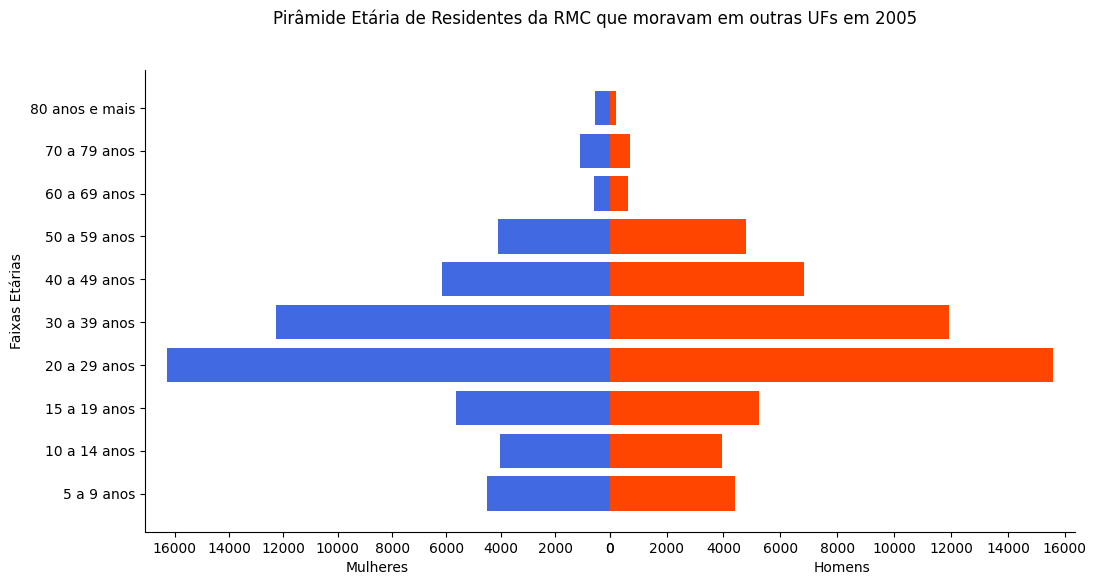

In [7]:
# Separação de dados por sexo
female_data = df_rec_migratorio_ufs.reset_index()[df_rec_migratorio_ufs.reset_index()['Sexo'] == 'Feminino']
male_data = df_rec_migratorio_ufs.reset_index()[df_rec_migratorio_ufs.reset_index()['Sexo'] == 'Masculino']

# Criação de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Adição de dados sobre migrantes de sexo feminino ao subplot 1
ax1.barh(female_data['Idade calculada, anos, classe'], female_data['Imigrantes de outras UFs'], color='royalblue')
ax1.set_xlabel('Mulheres')
ax1.set_ylabel('Faixas Etárias')
ax1.invert_xaxis()  # Invert the x-axis for female data to go left
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adição de dados sobre migrantes de sexo masculino ao subplot 2
ax2.barh(male_data['Idade calculada, anos, classe'], male_data['Imigrantes de outras UFs'], color='orangered')
ax2.set_xlabel('Homens')
ax2.set_yticks([])  # Remove the y-ticks on the male subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Título da Figura
fig.suptitle('Pirâmide Etária de Residentes da RMC que moravam em outras UFs em 2005')

# Ajuste de espaçamento entre os subplots
plt.subplots_adjust(wspace=0.0) 

# Show the plot
plt.show()


### Residentes da RMC em 01 de agosto de 2010 que moravam em outros países em 01 de agosto de 2005

No BME foram obtidos os dados de pessoas que disseram morar em outros países na data de 01 de agost de 2005, filtrados para o conjunto dos municípios da RMC, conforme sua delimitação em 2010, mais os três municípios que passaram a integrá-la posterioremente - Campo do Tenente, Piên e Rio Negro. Esses dados foram gravados em formato CSV, no arquivo "migracao 2010 - moradores RMC moravam em outro país em 2005 por idade e sexo.csv".

Adiante, carregamento e tratamentos semelhantes àqueles feitos na seção anterior.

In [8]:
# Identificação das colunas a serem importadas do arquivo, ignorando aquelas em que o BME apenas lança informações administrativas, como códigos internos
colunas_a_importar = [
    'Código do Item Geográfico', 'Item Geográfico',
    'Idade calculada, anos, classe',
    'Sexo',
    'Frequência', 'Observações']

# importação de dados em formato Pandas DataFrame
df_rec_migratorio_extrangeiros = pd.read_csv(
    '../source/tab/originais/dados migracao 2010/migracao 2010 - moradores RMC moravam em outro país em 2005 por idade e sexo.csv'
    , sep=';'
    , na_values='X'
    , usecols=colunas_a_importar

)

# atribuição de 0 para frequências com valor nulo
df_rec_migratorio_extrangeiros.fillna(0, inplace=True)

#  Mapeamento de faixas etárias do IBGE àquelas dos dados administrativos de mortalidade e natalidade
df_rec_migratorio_extrangeiros = (
    df_rec_migratorio_extrangeiros
    .replace(faixas_etarias)
    .groupby(
        by=['Sexo', 'Idade calculada, anos, classe', 'Código do Item Geográfico', 'Item Geográfico']
        , as_index=False)[['Frequência']]
        .sum()
        )


# Atribuindo tipo categoria ordenada para a coluna sobre faixa etária
categorias_etarias = [
    '5 a 9 anos', '10 a 14 anos', '15 a 19 anos', '20 a 29 anos'
    ,'30 a 39 anos', '40 a 49 anos', '50 a 59 anos', '60 a 69 anos'
    , '70 a 79 anos', '80 anos e mais']
df_rec_migratorio_extrangeiros['Idade calculada, anos, classe'] = df_rec_migratorio_extrangeiros['Idade calculada, anos, classe'].astype(pd.CategoricalDtype(categories=categorias_etarias, ordered=True))


# Atribuindo sexo e faixa etária como índice e fixando ordem crescente de faixas etárias.
df_rec_migratorio_extrangeiros.set_index(['Sexo', 'Idade calculada, anos, classe'], inplace=True)
df_rec_migratorio_extrangeiros.sort_index(inplace=True)


Na célula de código seguinte, o resultado da importação é apresentado, com as duas primerias e as duas últimas linhas do DataFrame.

In [9]:
df_rec_migratorio_extrangeiros.iloc[np.r_[0:2, -2:0]]

Código do Item Geográfico  \
Sexo      Idade calculada, anos, classe                              
Feminino  5 a 9 anos                                          2300   
          5 a 9 anos                                       4103107   
Masculino 80 anos e mais                                   4119509   
          80 anos e mais                                   4120804   

                                         Item Geográfico  Frequência  
Sexo      Idade calculada, anos, classe                               
Feminino  5 a 9 anos                         RM Curitiba       305.0  
          5 a 9 anos                     BOCAIÚVA DO SUL         0.0  
Masculino 80 anos e mais                       PIRAQUARA         0.0  
          80 anos e mais                   QUATRO BARRAS         0.0

Os dados para as diferentes unidades territoriais carregadas, RM Curitiba no recorte de 2010, mais os três municipíos acrescentados após o ano de 2010, foram devidamente incorporados ao total do recorte em vigência no momento da elaboração dos diagnósticos do PDUI-RMC.

In [10]:
df_rec_migratorio_extrangeiros = pd.concat(
    objs=[
        df_rec_migratorio_extrangeiros[df_rec_migratorio_extrangeiros['Item Geográfico'] == 'RM Curitiba'][['Frequência']].rename(columns={'Frequência':'RMC 2010'})
        , df_rec_migratorio_extrangeiros[df_rec_migratorio_extrangeiros['Item Geográfico'] == 'PIÊN'][['Frequência']].rename(columns={'Frequência':'Piên'})
        , df_rec_migratorio_extrangeiros[df_rec_migratorio_extrangeiros['Item Geográfico'] == 'RIO NEGRO'][['Frequência']].rename(columns={'Frequência':'Rio Negro'})
        , df_rec_migratorio_extrangeiros[df_rec_migratorio_extrangeiros['Item Geográfico'] == 'CAMPO DO TENENTE'][['Frequência']].rename(columns={'Frequência':'Campo do Tenente'})

    ]
    , axis=1

).fillna(0)


df_rec_migratorio_extrangeiros['Imigrantes de outras Países'] = df_rec_migratorio_extrangeiros.sum(axis=1)


df_rec_migratorio_extrangeiros.drop(columns=['RMC 2010', 'Piên', 'Rio Negro', 'Campo do Tenente'], inplace=True)


O resultado do tratamento dos dados pode ser observado adiante, de forma padronizada que permitirá o cálculo do saldo migrátorio no período em análise.

In [11]:
df_rec_migratorio_extrangeiros

Imigrantes de outras Países
Sexo      Idade calculada, anos, classe                             
Feminino  5 a 9 anos                                           305.0
          10 a 14 anos                                         253.0
          15 a 19 anos                                         122.0
          20 a 29 anos                                        1083.0
          30 a 39 anos                                        1059.0
          40 a 49 anos                                         688.0
          50 a 59 anos                                         235.0
          60 a 69 anos                                           0.0
          70 a 79 anos                                           0.0
          80 anos e mais                                         0.0
Masculino 5 a 9 anos                                           331.0
          10 a 14 anos                                         277.0
          15 a 19 anos                                         162.0
          20 a 29 anos                                         962.0
          30 a 39 anos                                        1182.0
          40 a 49 anos                                         675.0
          50 a 59 anos                                         362.0
          60 a 69 anos                                           0.0
          70 a 79 anos                                           0.0
          80 anos e mais                                         0.0

Na célula seguinte, é construída a pirâmide etária dos moradores da RMC em 2010 que, no ano de 2005, habitavam outros países.

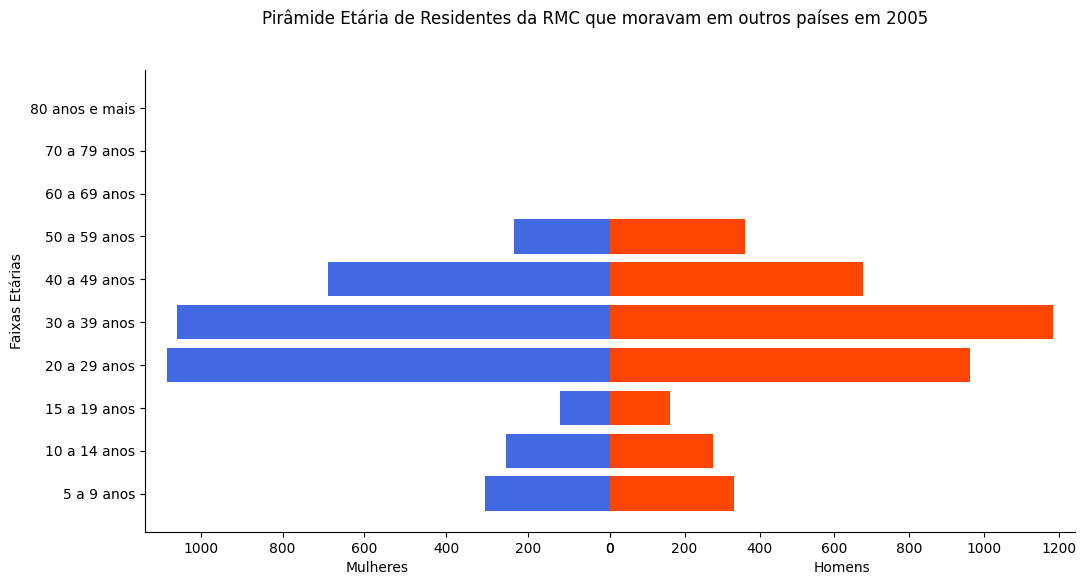

In [12]:
# Separação de dados por sexo
female_data = df_rec_migratorio_extrangeiros.reset_index()[df_rec_migratorio_extrangeiros.reset_index()['Sexo'] == 'Feminino']
male_data = df_rec_migratorio_extrangeiros.reset_index()[df_rec_migratorio_extrangeiros.reset_index()['Sexo'] == 'Masculino']

# Criação de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Adição de dados sobre migrantes de sexo feminino ao subplot 1
ax1.barh(female_data['Idade calculada, anos, classe'], female_data['Imigrantes de outras Países'], color='royalblue')
ax1.set_xlabel('Mulheres')
ax1.set_ylabel('Faixas Etárias')
ax1.invert_xaxis()  # Invert the x-axis for female data to go left
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adição de dados sobre migrantes de sexo masculino ao subplot 2
ax2.barh(male_data['Idade calculada, anos, classe'], male_data['Imigrantes de outras Países'], color='orangered')
ax2.set_xlabel('Homens')
ax2.set_yticks([])  # Remove the y-ticks on the male subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Título da Figura
fig.suptitle('Pirâmide Etária de Residentes da RMC que moravam em outros países em 2005')

# Ajuste de espaçamento entre os subplots
plt.subplots_adjust(wspace=0.0) 

# Show the plot
plt.show()


### Residentes da RMC em 01 de agosto de 2010 que moravam em outros municípios do Paraná em 2005

No BME foram obtidos os dados de pessoas que disseram morar em outros municípios do Estadod o Paraná, fora da Região Metropolitana, na data de 01 de agosto de 2005, filtrados para o conjunto dos municípios da RMC, conforme sua delimitação em 2010, mais os três municípios que passaram a integrá-la posterioremente - Campo do Tenente, Piên e Rio Negro. Esses dados foram gravados em formato CSV, no arquivo "migracao 2010 - moradores RMC moravam em outro municipio PR em 2005 por idade e sexo.csv".

Na célula seguinte, o processo de carregamento e tratamento está exposto, de maneira semelhante àquela nos casos anteriores.

In [13]:
colunas_a_importar = [
    'Código do Item Geográfico', 'Item Geográfico',
    'Idade calculada, anos, classe',
    'Sexo', 'Residência em 31/07/2005, município', 'Residência em 31/07/2005, município (código)',
    'Frequência', 'Observações']


df_recebimento_migratorio_PR = pd.read_csv(
    '../source/tab/originais/dados migracao 2010/migracao 2010 - moradores RMC moravam em outro municipio PR em 2005 por idade e sexo.csv'
    , sep=';'
    , na_values='X'
    , usecols=colunas_a_importar

)

df_recebimento_migratorio_PR = df_recebimento_migratorio_PR[~df_recebimento_migratorio_PR['Residência em 31/07/2005, município (código)'].isin(cod_municipios_rmc)]

df_recebimento_migratorio_PR = df_recebimento_migratorio_PR[df_recebimento_migratorio_PR['Item Geográfico'].isin(['RM Curitiba', 'PIÊN', 'RIO NEGRO', 'CAMPO DO TENENTE'])]


#  Mapeamento de faixas etárias do IBGE àquelas dos dados administrativos de mortalidade e natalidade
df_recebimento_migratorio_PR = (
    df_recebimento_migratorio_PR
    .replace(faixas_etarias)
    .groupby(
        by=['Sexo', 'Idade calculada, anos, classe', 'Item Geográfico']
        , as_index=False)[['Frequência']]
        .sum()
        )

df_recebimento_migratorio_PR.fillna(0, inplace=True)


# Atribuindo tipo categoria ordenada para a coluna sobre faixa etária
categorias_etarias = [
    '5 a 9 anos', '10 a 14 anos', '15 a 19 anos', '20 a 29 anos'
    ,'30 a 39 anos', '40 a 49 anos', '50 a 59 anos', '60 a 69 anos'
    , '70 a 79 anos', '80 anos e mais']
df_recebimento_migratorio_PR['Idade calculada, anos, classe'] = df_recebimento_migratorio_PR['Idade calculada, anos, classe'].astype(pd.CategoricalDtype(categories=categorias_etarias, ordered=True))


# Atribuindo sexo e faixa etária como índice e fixando ordem crescente de faixas etárias.
df_recebimento_migratorio_PR.set_index(['Sexo', 'Idade calculada, anos, classe'], inplace=True)
df_recebimento_migratorio_PR.sort_index(inplace=True)


In [14]:
df_recebimento_migratorio_PR

Item Geográfico  Frequência
Sexo      Idade calculada, anos, classe                              
Feminino  5 a 9 anos                     CAMPO DO TENENTE         0.0
          5 a 9 anos                                 PIÊN         0.0
          5 a 9 anos                            RIO NEGRO         0.0
          5 a 9 anos                          RM Curitiba       961.0
          10 a 14 anos                   CAMPO DO TENENTE         0.0
...                                                   ...         ...
Masculino 50 a 59 anos                        RM Curitiba       413.0
          60 a 69 anos                        RM Curitiba         0.0
          70 a 79 anos                               PIÊN         0.0
          70 a 79 anos                        RM Curitiba         0.0
          80 anos e mais                      RM Curitiba         0.0

[61 rows x 2 columns]

In [15]:
df_recebimento_migratorio_PR = pd.concat(
    objs=[
        df_recebimento_migratorio_PR[df_recebimento_migratorio_PR['Item Geográfico'] == 'RM Curitiba'][['Frequência']].rename(columns={'Frequência':'RMC 2010'})
        , df_recebimento_migratorio_PR[df_recebimento_migratorio_PR['Item Geográfico'] == 'PIÊN'][['Frequência']].rename(columns={'Frequência':'Piên'})
        , df_recebimento_migratorio_PR[df_recebimento_migratorio_PR['Item Geográfico'] == 'RIO NEGRO'][['Frequência']].rename(columns={'Frequência':'Rio Negro'})
        , df_recebimento_migratorio_PR[df_recebimento_migratorio_PR['Item Geográfico'] == 'CAMPO DO TENENTE'][['Frequência']].rename(columns={'Frequência':'Campo do Tenente'})

    ]
    , axis=1

).fillna(0)


df_recebimento_migratorio_PR['Imigrantes de outros municípios do PR'] = df_recebimento_migratorio_PR.sum(axis=1)


df_recebimento_migratorio_PR.drop(columns=['RMC 2010', 'Piên', 'Rio Negro', 'Campo do Tenente'], inplace=True)

O resultado do tratamento dos dados pode ser observado adiante, de forma padronizada que permitirá o cálculo do saldo migrátorio no período em análise.

In [16]:
df_recebimento_migratorio_PR

Imigrantes de outros municípios do PR
Sexo      Idade calculada, anos, classe                                       
Feminino  5 a 9 anos                                                     961.0
          10 a 14 anos                                                  1145.0
          15 a 19 anos                                                  1674.0
          20 a 29 anos                                                  6816.0
          30 a 39 anos                                                  2478.0
          40 a 49 anos                                                  1021.0
          50 a 59 anos                                                   326.0
          60 a 69 anos                                                     0.0
          70 a 79 anos                                                     0.0
          80 anos e mais                                                   0.0
Masculino 5 a 9 anos                                                     828.0
          10 a 14 anos                                                  1085.0
          15 a 19 anos                                                  1169.0
          20 a 29 anos                                                  6204.0
          30 a 39 anos                                                  2722.0
          40 a 49 anos                                                  1098.0
          50 a 59 anos                                                   413.0
          60 a 69 anos                                                     0.0
          70 a 79 anos                                                     0.0
          80 anos e mais                                                   0.0

Com base nesses dados, foi elaborada a Pirâmide Etária adiante, que mostra um significativo predomínio de migrantes nas faixas entre 20 e 29 anos, de ambos os sexos, oriundos de outras partes do Estado do Paraná.

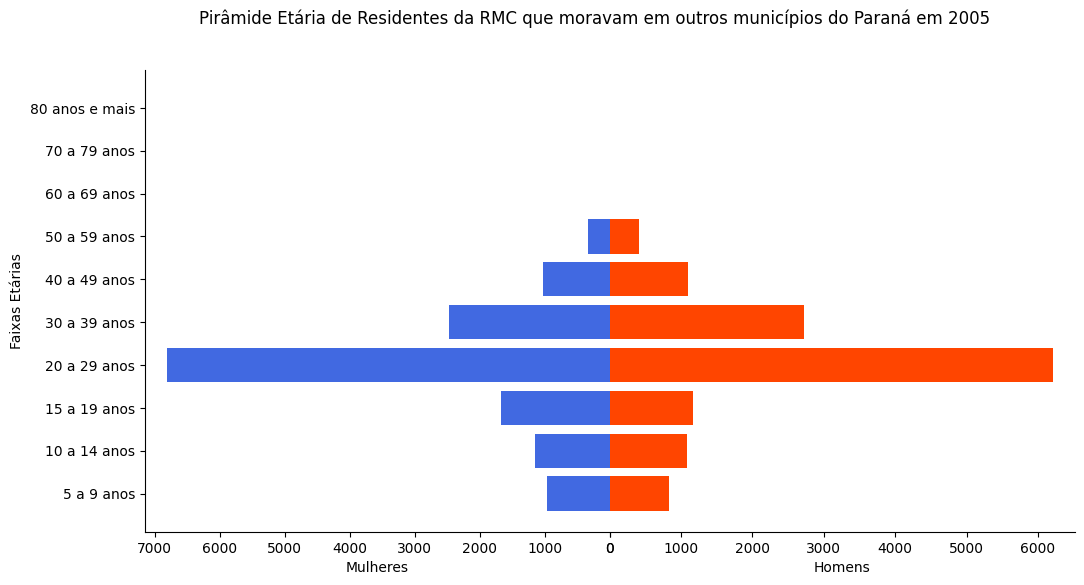

In [17]:
# Separação de dados por sexo
female_data = df_recebimento_migratorio_PR.reset_index()[df_recebimento_migratorio_PR.reset_index()['Sexo'] == 'Feminino']
male_data = df_recebimento_migratorio_PR.reset_index()[df_recebimento_migratorio_PR.reset_index()['Sexo'] == 'Masculino']

# Criação de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Adição de dados sobre migrantes de sexo feminino ao subplot 1
ax1.barh(female_data['Idade calculada, anos, classe'], female_data['Imigrantes de outros municípios do PR'], color='royalblue')
ax1.set_xlabel('Mulheres')
ax1.set_ylabel('Faixas Etárias')
ax1.invert_xaxis()  # Invert the x-axis for female data to go left
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adição de dados sobre migrantes de sexo masculino ao subplot 2
ax2.barh(male_data['Idade calculada, anos, classe'], male_data['Imigrantes de outros municípios do PR'], color='orangered')
ax2.set_xlabel('Homens')
ax2.set_yticks([])  # Remove the y-ticks on the male subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Título da Figura
fig.suptitle('Pirâmide Etária de Residentes da RMC que moravam em outros municípios do Paraná em 2005')

# Ajuste de espaçamento entre os subplots
plt.subplots_adjust(wspace=0.0) 

# Show the plot
plt.show()


### Pessoas na RMC que moravam em outros estados, países ou municípios do Paraná exclusive aqueles da RMC

A concatenação dos dados acima mostra que 169.633 pessoas que moravam na RMC, em 2010, habitavam outras áreas do estado do Paraná, outros estados ou mesmo outros países cinco anos antes, conforme se pode verificar abaixo

In [18]:
imigrantes_quinquenio = (df_recebimento_migratorio_PR['Imigrantes de outros municípios do PR'].sum() + df_rec_migratorio_extrangeiros['Imigrantes de outras Países'].sum() + df_rec_migratorio_ufs['Imigrantes de outras UFs'].sum())

print(f'Imigrantes entre 2005 e 2010: {int(imigrantes_quinquenio)}')
print(f'Média Anual de imigrantes entre 2005 e 2010: {int(imigrantes_quinquenio / 5)}')

Imigrantes entre 2005 e 2010: 145170
Média Anual de imigrantes entre 2005 e 2010: 29034


In [19]:
df_chegadas = pd.concat(
    objs = [
        df_recebimento_migratorio_PR
        , df_rec_migratorio_extrangeiros
        , df_rec_migratorio_ufs
        ]
    ,axis=1
).fillna(0).astype(int)

df_chegadas['Total'] = df_chegadas.sum(axis=1)

In [20]:
df_chegadas

Imigrantes de outros municípios do PR  \
Sexo      Idade calculada, anos, classe                                          
Feminino  5 a 9 anos                                                       961   
          10 a 14 anos                                                    1145   
          15 a 19 anos                                                    1674   
          20 a 29 anos                                                    6816   
          30 a 39 anos                                                    2478   
          40 a 49 anos                                                    1021   
          50 a 59 anos                                                     326   
          60 a 69 anos                                                       0   
          70 a 79 anos                                                       0   
          80 anos e mais                                                     0   
Masculino 5 a 9 anos                                                       828   
          10 a 14 anos                                                    1085   
          15 a 19 anos                                                    1169   
          20 a 29 anos                                                    6204   
          30 a 39 anos                                                    2722   
          40 a 49 anos                                                    1098   
          50 a 59 anos                                                     413   
          60 a 69 anos                                                       0   
          70 a 79 anos                                                       0   
          80 anos e mais                                                     0   

                                         Imigrantes de outras Países  \
Sexo      Idade calculada, anos, classe                                
Feminino  5 a 9 anos                                             305   
          10 a 14 anos                                           253   
          15 a 19 anos                                           122   
          20 a 29 anos                                          1083   
          30 a 39 anos                                          1059   
          40 a 49 anos                                           688   
          50 a 59 anos                                           235   
          60 a 69 anos                                             0   
          70 a 79 anos                                             0   
          80 anos e mais                                           0   
Masculino 5 a 9 anos                                             331   
          10 a 14 anos                                           277   
          15 a 19 anos                                           162   
          20 a 29 anos                                           962   
          30 a 39 anos                                          1182   
          40 a 49 anos                                           675   
          50 a 59 anos                                           362   
          60 a 69 anos                                             0   
          70 a 79 anos                                             0   
          80 anos e mais                                           0   

                                         Imigrantes de outras UFs  Total  
Sexo      Idade calculada, anos, classe                                   
Feminino  5 a 9 anos                                         4513   5779  
          10 a 14 anos                                       4033   5431  
          15 a 19 anos                                       5664   7460  
          20 a 29 anos                                      16286  24185  
          30 a 39 anos                                      12272  15809  
          40 a 49 anos                                       6166   7875  
          50 a 59 anos                             

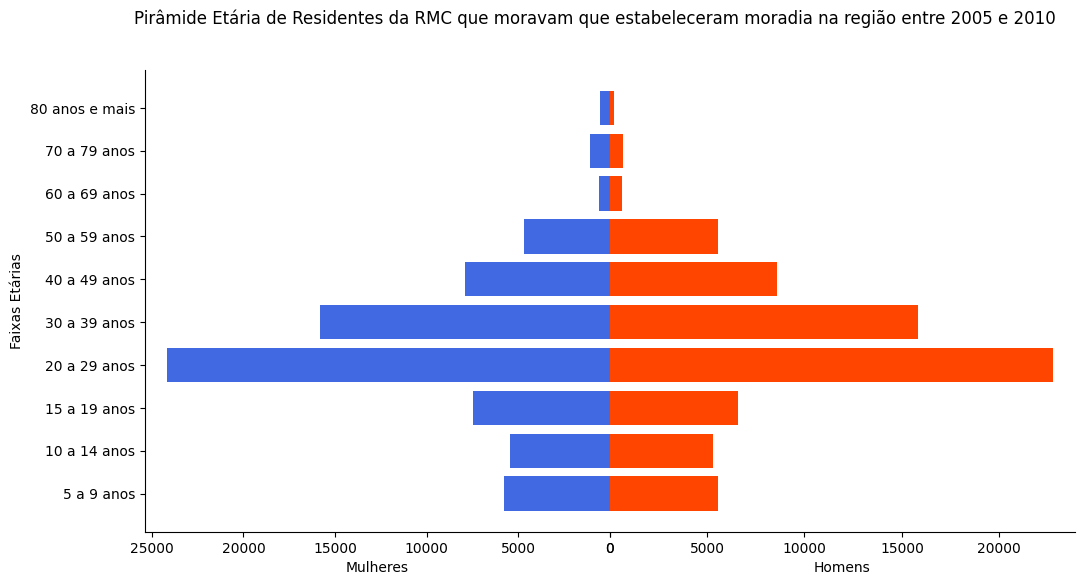

In [21]:
# Separação de dados por sexo
female_data = df_chegadas.reset_index()[df_chegadas.reset_index()['Sexo'] == 'Feminino']
male_data = df_chegadas.reset_index()[df_chegadas.reset_index()['Sexo'] == 'Masculino']

# Criação de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Adição de dados sobre migrantes de sexo feminino ao subplot 1
ax1.barh(female_data['Idade calculada, anos, classe'], female_data['Total'], color='royalblue')
ax1.set_xlabel('Mulheres')
ax1.set_ylabel('Faixas Etárias')
ax1.invert_xaxis()  # Invert the x-axis for female data to go left
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adição de dados sobre migrantes de sexo masculino ao subplot 2
ax2.barh(male_data['Idade calculada, anos, classe'], male_data['Total'], color='orangered')
ax2.set_xlabel('Homens')
ax2.set_yticks([])  # Remove the y-ticks on the male subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Título da Figura
fig.suptitle('Pirâmide Etária de Residentes da RMC que moravam que estabeleceram moradia na região entre 2005 e 2010')

# Ajuste de espaçamento entre os subplots
plt.subplots_adjust(wspace=0.0) 

# Show the plot
plt.show()


# Pessoas que saíram da RMC entre 2005 e 2010

### Carregamento dos Dados de Pessoas que saíram da RMC para outros municípios do PR entre 2005 e 2010

In [22]:
colunas_a_importar = [
    'Código do Item Geográfico', 'Item Geográfico',
    'Idade calculada, anos, classe',
    'Sexo', 'Residência em 31/07/2005, município', 'Residência em 31/07/2005, município (código)',
    'Frequência', 'Observações']


df_perdas_migratorias_PR = pd.read_csv(
    '../source/tab/originais/dados migracao 2010/bme saída rmc p outros municipios pr 2005 a 2010 por sexo e idade.csv'
    , sep=';'
    , na_values='X'
    , usecols=colunas_a_importar

)

df_perdas_migratorias_PR = (
    df_perdas_migratorias_PR
    .replace(faixas_etarias)
    .groupby(
        by=['Sexo', 'Idade calculada, anos, classe', 'Código do Item Geográfico', 'Item Geográfico']
        , as_index=False)[['Frequência']]
        .sum()
        )


df_perdas_migratorias_PR.fillna(0, inplace=True)

# Atribuindo tipo categoria ordenada para a coluna sobre faixa etária
categorias_etarias = [
    '5 a 9 anos', '10 a 14 anos', '15 a 19 anos', '20 a 29 anos'
    ,'30 a 39 anos', '40 a 49 anos', '50 a 59 anos', '60 a 69 anos'
    , '70 a 79 anos', '80 anos e mais']
df_perdas_migratorias_PR['Idade calculada, anos, classe'] = df_perdas_migratorias_PR['Idade calculada, anos, classe'].astype(pd.CategoricalDtype(categories=categorias_etarias, ordered=True))


# Atribuindo sexo e faixa etária como índice e fixando ordem crescente de faixas etárias.
df_perdas_migratorias_PR.set_index(['Sexo', 'Idade calculada, anos, classe'], inplace=True)
df_perdas_migratorias_PR.sort_index(inplace=True)

In [23]:
df_perdas_migratorias_PR.iloc[np.r_[0:2, -2:0]]

Código do Item Geográfico  \
Sexo      Idade calculada, anos, classe                              
Feminino  5 a 9 anos                                            23   
          5 a 9 anos                                            41   
Masculino 80 anos e mais                                        41   
          80 anos e mais                                   4104105   

                                          Item Geográfico  Frequência  
Sexo      Idade calculada, anos, classe                                
Feminino  5 a 9 anos                          RM Curitiba      8209.0  
          5 a 9 anos                               Paraná     11182.0  
Masculino 80 anos e mais                           Paraná       198.0  
          80 anos e mais                 CAMPO DO TENENTE         0.0

In [24]:
df_perdas_migratorias_PR = pd.concat(
    objs=[
        df_perdas_migratorias_PR[df_perdas_migratorias_PR['Item Geográfico'] == 'Paraná'][['Frequência']].rename(columns={'Frequência':'Paraná'})
        , df_perdas_migratorias_PR[df_perdas_migratorias_PR['Item Geográfico'] == 'RM Curitiba'][['Frequência']].rename(columns={'Frequência':'RM Curitiba'})
        , df_perdas_migratorias_PR[df_perdas_migratorias_PR['Item Geográfico'] == 'RIO NEGRO'][['Frequência']].rename(columns={'Frequência':'Rio Negro'})
        , df_perdas_migratorias_PR[df_perdas_migratorias_PR['Item Geográfico'] == 'PIÊN'][['Frequência']].rename(columns={'Frequência':'Piên'})
        , df_perdas_migratorias_PR[df_perdas_migratorias_PR['Item Geográfico'] == 'PIÊN'][['Frequência']].rename(columns={'Frequência':'Campo do Tenente'})
    ]
    , axis=1
).fillna(0)

# Nas migrações internas ao território paranaense, são subtraídas aquelas que tiveram como destino a RMC
df_perdas_migratorias_PR['Moradores PR que Saíram da RM desde 2005'] = (df_perdas_migratorias_PR['Paraná'] - df_perdas_migratorias_PR.iloc[:,1:].sum(axis=1)).astype(int)
# Deleção de colunas desnecessárias
df_perdas_migratorias_PR.drop(columns=['Paraná', 'RM Curitiba', 'Rio Negro', 'Piên', 'Campo do Tenente'], inplace=True)

In [25]:
df_perdas_migratorias_PR

Moradores PR que Saíram da RM desde 2005
Sexo      Idade calculada, anos, classe                                          
Feminino  5 a 9 anos                                                         2913
          10 a 14 anos                                                       2995
          15 a 19 anos                                                       2243
          20 a 29 anos                                                       5604
          30 a 39 anos                                                       5997
          40 a 49 anos                                                       3628
          50 a 59 anos                                                       3396
          60 a 69 anos                                                        650
          70 a 79 anos                                                        370
          80 anos e mais                                                      218
Masculino 5 a 9 anos                                                         2896
          10 a 14 anos                                                       3089
          15 a 19 anos                                                       2272
          20 a 29 anos                                                       4897
          30 a 39 anos                                                       6273
          40 a 49 anos                                                       3798
          50 a 59 anos                                                       3424
          60 a 69 anos                                                        730
          70 a 79 anos                                                        512
          80 anos e mais                                                       88

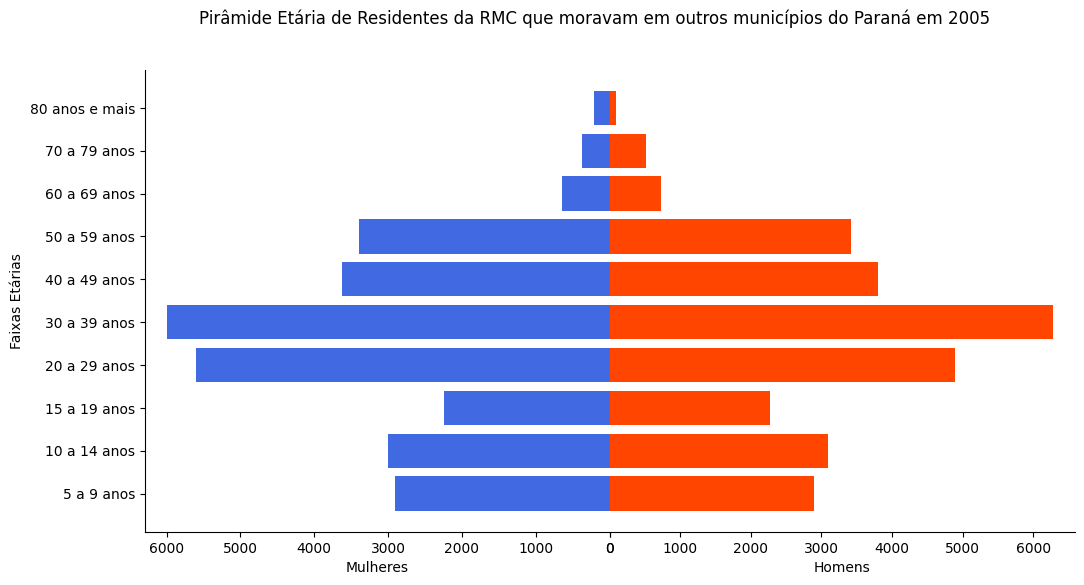

In [26]:
# Separação de dados por sexo
female_data = df_perdas_migratorias_PR.reset_index()[df_perdas_migratorias_PR.reset_index()['Sexo'] == 'Feminino']
male_data = df_perdas_migratorias_PR.reset_index()[df_perdas_migratorias_PR.reset_index()['Sexo'] == 'Masculino']

# Criação de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Adição de dados sobre migrantes de sexo feminino ao subplot 1
ax1.barh(female_data['Idade calculada, anos, classe'], female_data['Moradores PR que Saíram da RM desde 2005'], color='royalblue')
ax1.set_xlabel('Mulheres')
ax1.set_ylabel('Faixas Etárias')
ax1.invert_xaxis()  # Invert the x-axis for female data to go left
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adição de dados sobre migrantes de sexo masculino ao subplot 2
ax2.barh(male_data['Idade calculada, anos, classe'], male_data['Moradores PR que Saíram da RM desde 2005'], color='orangered')
ax2.set_xlabel('Homens')
ax2.set_yticks([])  # Remove the y-ticks on the male subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Título da Figura
fig.suptitle('Pirâmide Etária de Residentes da RMC que moravam em outros municípios do Paraná em 2005')

# Ajuste de espaçamento entre os subplots
plt.subplots_adjust(wspace=0.0) 

# Show the plot
plt.show()


### Carregamento dos Dados de Pessoas que saíram da RMC para outros Estados entre 2005 e 2010

In [27]:
colunas_a_importar = [
    'Código do Item Geográfico', 'Item Geográfico',
    'Idade calculada, anos, classe',
    'Sexo', 'Residência em 31/07/2005, município', 'Residência em 31/07/2005, município (código)',
    'Frequência', 'Observações']


df_perdas_migratorias_outras_ufs = pd.read_csv(
    '../source/tab/originais/dados migracao 2010/bme saída rmc p outras regioes e ufs 2005 a 2010 por sexo e idade.csv'
    , sep=';'
    , na_values='X'
    , usecols=colunas_a_importar

)

df_perdas_migratorias_outras_ufs = (
    df_perdas_migratorias_outras_ufs
    .replace(faixas_etarias)
    .groupby(
        by=['Sexo', 'Idade calculada, anos, classe']
        , as_index=False)[['Frequência']]
        .sum()
        )


df_perdas_migratorias_outras_ufs.fillna(0, inplace=True)


# Atribuindo tipo categoria ordenada para a coluna sobre faixa etária
categorias_etarias = [
    '5 a 9 anos', '10 a 14 anos', '15 a 19 anos', '20 a 29 anos'
    ,'30 a 39 anos', '40 a 49 anos', '50 a 59 anos', '60 a 69 anos'
    , '70 a 79 anos', '80 anos e mais']
df_perdas_migratorias_outras_ufs['Idade calculada, anos, classe'] = df_perdas_migratorias_outras_ufs['Idade calculada, anos, classe'].astype(pd.CategoricalDtype(categories=categorias_etarias, ordered=True))



df_perdas_migratorias_outras_ufs.set_index(['Sexo', 'Idade calculada, anos, classe'], inplace=True)

df_perdas_migratorias_outras_ufs['Frequência'] = df_perdas_migratorias_outras_ufs['Frequência'].astype(int)

df_perdas_migratorias_outras_ufs.sort_index(inplace=True)

df_perdas_migratorias_outras_ufs.columns = ['Moradores de outras UFs que saíram da RMC']
df_perdas_migratorias_outras_ufs

Moradores de outras UFs que saíram da RMC
Sexo      Idade calculada, anos, classe                                           
Feminino  5 a 9 anos                                                          2771
          10 a 14 anos                                                        2640
          15 a 19 anos                                                        1832
          20 a 29 anos                                                        7201
          30 a 39 anos                                                        6969
          40 a 49 anos                                                        4014
          50 a 59 anos                                                        2670
          60 a 69 anos                                                         575
          70 a 79 anos                                                         523
          80 anos e mais                                                       122
Masculino 5 a 9 anos                                                          2734
          10 a 14 anos                                                        2544
          15 a 19 anos                                                        2028
          20 a 29 anos                                                        7066
          30 a 39 anos                                                        7533
          40 a 49 anos                                                        4380
          50 a 59 anos                                                        2784
          60 a 69 anos                                                         381
          70 a 79 anos                                                         397
          80 anos e mais                                                         0

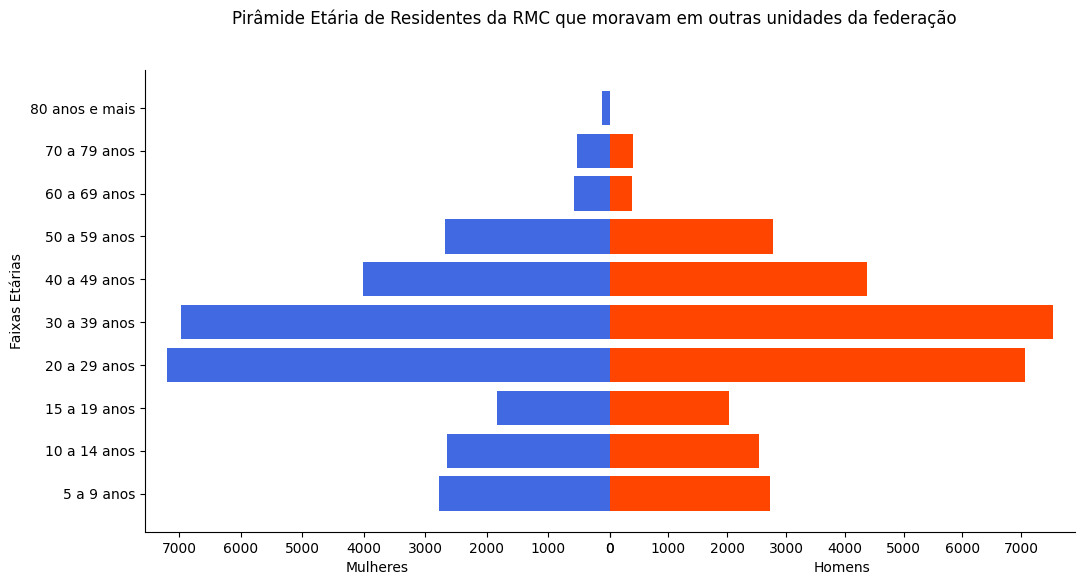

In [28]:
# Separação de dados por sexo
female_data = df_perdas_migratorias_outras_ufs.reset_index()[df_perdas_migratorias_outras_ufs.reset_index()['Sexo'] == 'Feminino']
male_data = df_perdas_migratorias_outras_ufs.reset_index()[df_perdas_migratorias_outras_ufs.reset_index()['Sexo'] == 'Masculino']

# Criação de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Adição de dados sobre migrantes de sexo feminino ao subplot 1
ax1.barh(female_data['Idade calculada, anos, classe'], female_data['Moradores de outras UFs que saíram da RMC'], color='royalblue')
ax1.set_xlabel('Mulheres')
ax1.set_ylabel('Faixas Etárias')
ax1.invert_xaxis()  # Invert the x-axis for female data to go left
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adição de dados sobre migrantes de sexo masculino ao subplot 2
ax2.barh(male_data['Idade calculada, anos, classe'], male_data['Moradores de outras UFs que saíram da RMC'], color='orangered')
ax2.set_xlabel('Homens')
ax2.set_yticks([])  # Remove the y-ticks on the male subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Título da Figura
fig.suptitle('Pirâmide Etária de Residentes da RMC que moravam em outras unidades da federação')

# Ajuste de espaçamento entre os subplots
plt.subplots_adjust(wspace=0.0) 

# Show the plot
plt.show()


### Pessoas que saíram da RMC para outros países entre 2005 e 2010
É um proxi. Nada diz que as pessoas que saíram do domicílio e foram para outro país o fizeram quando aquela família se encontrava no município da entrevista.

In [29]:
df_perda_migratoria_internacional_rmc = pd.read_csv(
    '../source/tab/originais/dados migracao 2010/bme saída rmc p outros países 2001 a 2010 por sexo e idade.csv'
    , sep=';'
    ,na_values='X'
)

df_perda_migratoria_internacional_rmc.fillna(0, inplace=True)


In [30]:
df_perda_migratoria_internacional_rmc

,Código do Nível Geográfico,Nível Geográfico,Código do Item Geográfico,Item Geográfico,Ordem Geográfica,Código do Item Temporal,Nível Temporal,Item Temporal,Sexo,Sexo (código),Sexo (ordem),"Emigrante, nascimento, ano","Emigrante, nascimento, ano (código)","Emigrante, nascimento, ano (ordem)","Emigrante, ano da partida, classe","Emigrante, ano da partida, classe (código)","Emigrante, ano da partida, classe (ordem)",Frequência,Observações
0,9239,"Região Metropolitana, colar, etc (2010)",23,RM Curitiba,1,2010,8030,31/07/2010,Masculino,1,1,1930,62,62,2008,140,140,0.0,0.0
1,9239,"Região Metropolitana, colar, etc (2010)",23,RM Curitiba,1,2010,8030,31/07/2010,Masculino,1,1,1930,62,62,2010,142,142,0.0,0.0
2,9239,"Região Metropolitana, colar, etc (2010)",23,RM Curitiba,1,2010,8030,31/07/2010,Masculino,1,1,1931,63,63,2009,141,141,0.0,0.0
3,9239,"Região Metropolitana, colar, etc (2010)",23,RM Curitiba,1,2010,8030,31/07/2010,Masculino,1,1,1935,67,67,2009,141,141,0.0,0.0
4,9239,"Região Metropolitana, colar, etc (2010)",23,RM Curitiba,1,2010,8030,31/07/2010,Masculino,1,1,1935,67,67,2010,142,142,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,9235,Município (2010),4122305,RIO NEGRO,30,2010,8030,31/07/2010,Masculino,1,1,1986,118,118,2010,142,142,0.0,0.0
1313,9235,Município (2010),4122305,RIO NEGRO,30,2010,8030,31/07/2010,Masculino,1,1,1988,120,120,2010,142,142,68.0,6.0
1314,9235,Município (2010),4122305,RIO NEGRO,30,2010,8030,31/07/2010,Feminino,2,2,1981,113,113,2010,142,142,0.0,0.0
1315,9235,Município (2010),4122305,RIO NEGRO,30,2010,8030,31/07/2010,Feminino,2,2,1986,118,118,2010,142,142,0.0,0.0


In [31]:
df_perda_migratoria_internacional_rmc = df_perda_migratoria_internacional_rmc.loc[df_perda_migratoria_internacional_rmc['Nível Geográfico'] == 'Região Metropolitana, colar, etc (2010)'][['Sexo', 'Emigrante, ano da partida, classe', 'Emigrante, nascimento, ano', 'Frequência']].pivot_table(
    columns='Emigrante, ano da partida, classe', index=['Sexo','Emigrante, nascimento, ano'], values='Frequência', aggfunc='sum').fillna(0)

In [32]:
df_perda_migratoria_internacional_rmc.reset_index(inplace=True)

In [33]:
df_perda_migratoria_internacional_rmc.columns.name = None

In [34]:
df_faixas_etarias = df_perda_migratoria_internacional_rmc.copy(deep=True)

In [35]:
for row in df_perda_migratoria_internacional_rmc.iterrows():
    df_faixas_etarias.iloc[row[0], 2:] = row[1][2:].index.astype(int) - row[1]['Emigrante, nascimento, ano']


In [36]:
dtypes_dict = {coluna:int for coluna in range(2001, 2011)}

In [37]:
df_faixas_etarias = df_faixas_etarias.astype(dtypes_dict)

In [38]:
df_faixas_etarias.set_index(['Sexo', 'Emigrante, nascimento, ano'], inplace=True)

In [39]:
df_mapa_faixas_etarias = pd.read_csv(
    '../source/tab/originais/mapa_faixas_etarias_e_anos.csv'
    , sep=';'
)
dict_map_faixas_idades = {row[1]['idade']:row[1]['Faixa Etária'] for row in df_mapa_faixas_etarias.iterrows()}

In [40]:
df_faixas_etarias = df_faixas_etarias.loc[:,list(range(2005, 2011))].replace(dict_map_faixas_idades)

In [41]:
df_faixas_etarias

2005          2006  \
Sexo      Emigrante, nascimento, ano                               
Feminino  1930                        70 a 79 anos  70 a 79 anos   
          1931                        70 a 79 anos  70 a 79 anos   
          1935                        70 a 79 anos  70 a 79 anos   
          1942                        60 a 69 anos  60 a 69 anos   
          1944                        60 a 69 anos  60 a 69 anos   
...                                            ...           ...   
Masculino 1995                        10 a 14 anos  10 a 14 anos   
          1997                          5 a 9 anos    5 a 9 anos   
          1998                          5 a 9 anos    5 a 9 anos   
          2000                          5 a 9 anos    5 a 9 anos   
          2005                          0 a 4 anos    0 a 4 anos   

                                              2007          2008  \
Sexo      Emigrante, nascimento, ano                               
Feminino  1930                        70 a 79 anos  70 a 79 anos   
          1931                        70 a 79 anos  70 a 79 anos   
          1935                        70 a 79 anos  70 a 79 anos   
          1942                        60 a 69 anos  60 a 69 anos   
          1944                        60 a 69 anos  60 a 69 anos   
...                                            ...           ...   
Masculino 1995                        10 a 14 anos  10 a 14 anos   
          1997                        10 a 14 anos  10 a 14 anos   
          1998                          5 a 9 anos  10 a 14 anos   
          2000                          5 a 9 anos    5 a 9 anos   
          2005                          0 a 4 anos    0 a 4 anos   

                                              2009            2010  
Sexo      Emigrante, nascimento, ano                                
Feminino  1930                        70 a 79 anos  80 anos e mais  
          1931                        70 a 79 anos    70 a 79 anos  
          1935                        70 a 79 anos    70 a 79 anos  
          1942                        60 a 69 anos    60 a 69 anos  
          1944                        60 a 69 anos    60 a 69 anos  
...                                            ...             ...  
Masculino 1995                        10 a 14 anos    15 a 19 anos  
          1997                        10 a 14 anos    10 a 14 anos  
          1998                        10 a 14 anos    10 a 14 anos  
          2000                          5 a 9 anos    10 a 14 anos  
          2005                          0 a 4 anos      5 a 9 anos  

[117 rows x 6 columns]

In [42]:
df_perda_migratoria_internacional_rmc.set_index(['Sexo', 'Emigrante, nascimento, ano'], inplace=True)

In [43]:
df_perda_migratoria_internacional_rmc = df_perda_migratoria_internacional_rmc.loc[:,list(range(2005, 2011))].join(other=df_faixas_etarias, rsuffix='-Faixa')

In [44]:
dict_dfs = dict()
for ano in range(2005, 2011):

   
   
   dict_dfs[ano] = (
      df_perda_migratoria_internacional_rmc
      .reset_index()
      .loc[:,['Sexo', str(ano), f'{ano}-Faixa']]
      .rename(columns={f'{ano}-Faixa':'Idade calculada, anos, classe'})
      .groupby(['Sexo', 'Idade calculada, anos, classe']).sum()
      .sort_index()
      .fillna(0)
      )

In [45]:
df_perda_migratoria_internacional_rmc = pd.concat(
    objs=dict_dfs.values()
    , axis=1
).sort_index().fillna(0).astype(int)

In [46]:
df_perda_migratoria_internacional_rmc.sum()

2005     403
2006    1203
2007    1561
2008    1484
2009    5237
2010    7093
dtype: int64

dados de 2010 podem estar com problemas de identificação de moradias temporárias no exterior como uma mudança permanente, ao passo que dados dos anos anteriores podem sofrer com erros de subcontagem. Optou-se por fazer uma ponderação entre os anos de 2009 e 2010 para assumir como valores médios de emigração internacional anual.

In [47]:
# De 1 de janeiro a 1 de agosto de 2010, 213 dias passaram, dos 365 do ano.
# df_perda_migratoria_internacional_rmc = (((df_perda_migratoria_internacional_rmc['2010'] / (213 / 365)) + df_perda_migratoria_internacional_rmc['2009']) / 2).astype(int).to_frame().rename(columns={0:'Emigrantes Internacionais'})

Alternativa, pegar só média de 2009 e 2010

In [48]:
df_perda_migratoria_internacional_rmc = ((df_perda_migratoria_internacional_rmc['2010'] + df_perda_migratoria_internacional_rmc['2009']) / 2).astype(int).to_frame().rename(columns={0:'Emigrantes Internacionais'})

In [49]:
df_perda_migratoria_internacional_rmc.sum()

Emigrantes Internacionais    6164
dtype: int64

In [50]:
df_perda_migratoria_internacional_rmc.reset_index(inplace=True)

In [51]:
df_perda_migratoria_internacional_rmc['Idade calculada, anos, classe'].unique()

array(['0 a 4 anos', '10 a 14 anos', '15 a 19 anos', '20 a 29 anos',
       '30 a 39 anos', '40 a 49 anos', '5 a 9 anos', '50 a 59 anos',
       '60 a 69 anos', '70 a 79 anos', '80 anos e mais'], dtype=object)

In [52]:
df_perda_migratoria_internacional_rmc = df_perda_migratoria_internacional_rmc[df_perda_migratoria_internacional_rmc['Idade calculada, anos, classe'] != '0 a 4 anos']

In [53]:
# Atribuindo tipo categoria ordenada para a coluna sobre faixa etária
categorias_etarias = [
    '5 a 9 anos', '10 a 14 anos', '15 a 19 anos', '20 a 29 anos'
    ,'30 a 39 anos', '40 a 49 anos', '50 a 59 anos', '60 a 69 anos'
    , '70 a 79 anos', '80 anos e mais']
df_perda_migratoria_internacional_rmc['Idade calculada, anos, classe'] = df_perda_migratoria_internacional_rmc['Idade calculada, anos, classe'].astype(pd.CategoricalDtype(categories=categorias_etarias, ordered=True))

In [54]:
df_perda_migratoria_internacional_rmc.set_index(['Sexo', 'Idade calculada, anos, classe'], inplace=True)
df_perda_migratoria_internacional_rmc.sort_index(inplace=True)

In [55]:
df_perda_migratoria_internacional_rmc

Emigrantes Internacionais
Sexo      Idade calculada, anos, classe                           
Feminino  5 a 9 anos                                             0
          10 a 14 anos                                           0
          15 a 19 anos                                         179
          20 a 29 anos                                        1862
          30 a 39 anos                                        1095
          40 a 49 anos                                         199
          50 a 59 anos                                          78
          60 a 69 anos                                           0
          70 a 79 anos                                           0
          80 anos e mais                                         0
Masculino 5 a 9 anos                                             0
          10 a 14 anos                                           0
          15 a 19 anos                                          69
          20 a 29 anos                                        1591
          30 a 39 anos                                         895
          40 a 49 anos                                         121
          50 a 59 anos                                          75
          60 a 69 anos                                           0
          70 a 79 anos                                           0
          80 anos e mais                                         0

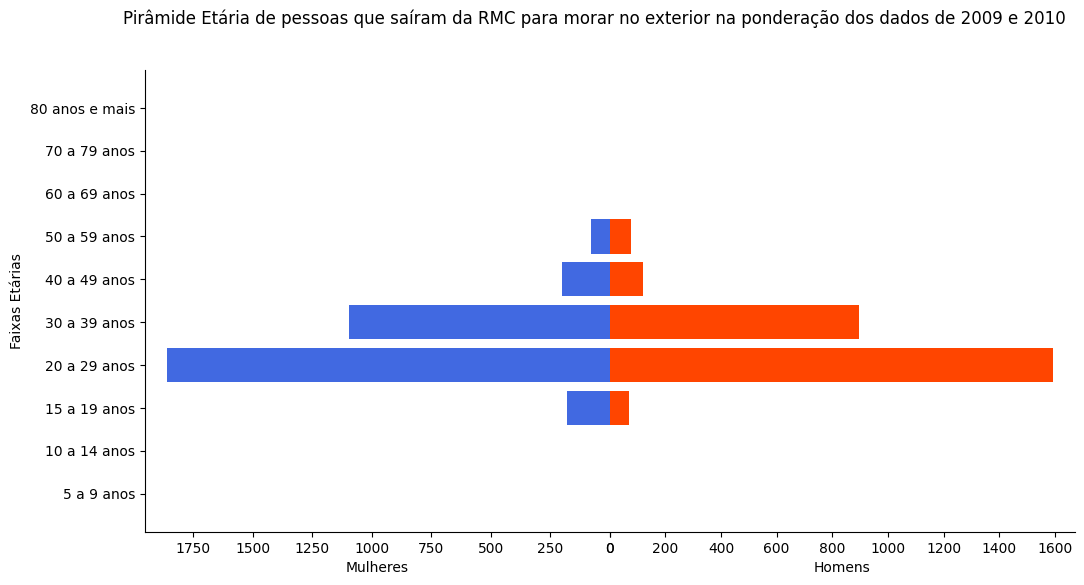

In [56]:
# Separação de dados por sexo
female_data = df_perda_migratoria_internacional_rmc.reset_index()[df_perda_migratoria_internacional_rmc.reset_index()['Sexo'] == 'Feminino']
male_data = df_perda_migratoria_internacional_rmc.reset_index()[df_perda_migratoria_internacional_rmc.reset_index()['Sexo'] == 'Masculino']

# Criação de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Adição de dados sobre migrantes de sexo feminino ao subplot 1
ax1.barh(female_data['Idade calculada, anos, classe'], female_data['Emigrantes Internacionais'], color='royalblue')
ax1.set_xlabel('Mulheres')
ax1.set_ylabel('Faixas Etárias')
ax1.invert_xaxis()  # Invert the x-axis for female data to go left
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adição de dados sobre migrantes de sexo masculino ao subplot 2
ax2.barh(male_data['Idade calculada, anos, classe'], male_data['Emigrantes Internacionais'], color='orangered')
ax2.set_xlabel('Homens')
ax2.set_yticks([])  # Remove the y-ticks on the male subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Título da Figura
fig.suptitle('Pirâmide Etária de pessoas que saíram da RMC para morar no exterior na ponderação dos dados de 2009 e 2010')

# Ajuste de espaçamento entre os subplots
plt.subplots_adjust(wspace=0.0) 

# Show the plot
plt.show()


In [57]:
emigrantes_quinquenio = (df_recebimento_migratorio_PR['Imigrantes de outros municípios do PR'].sum() + df_rec_migratorio_extrangeiros['Imigrantes de outras Países'].sum() + df_rec_migratorio_ufs['Imigrantes de outras UFs'].sum())

print(f'Imigrantes entre 2005 e 2010: {int(imigrantes_quinquenio)}')
print(f'Média Anual de imigrantes entre 2005 e 2010: {int(imigrantes_quinquenio / 5)}')

Imigrantes entre 2005 e 2010: 145170
Média Anual de imigrantes entre 2005 e 2010: 29034


PRECISO ESTAR ALERTGA AQUI ABAIXO O VALOR MÉDIO DA PONDERAÇÃO 2009 E 2010 FOI MULTIPLICADA POR 5

In [58]:
df_saidas = pd.concat(
    objs = [
        df_perdas_migratorias_PR
        , df_perdas_migratorias_outras_ufs
        , df_perda_migratoria_internacional_rmc * 5
        ]
    ,axis=1
).fillna(0).astype(int)

df_saidas['Total'] = df_saidas.sum(axis=1)

In [59]:
df_saidas

Moradores PR que Saíram da RM desde 2005  \
Sexo      Idade calculada, anos, classe                                             
Feminino  5 a 9 anos                                                         2913   
          10 a 14 anos                                                       2995   
          15 a 19 anos                                                       2243   
          20 a 29 anos                                                       5604   
          30 a 39 anos                                                       5997   
          40 a 49 anos                                                       3628   
          50 a 59 anos                                                       3396   
          60 a 69 anos                                                        650   
          70 a 79 anos                                                        370   
          80 anos e mais                                                      218   
Masculino 5 a 9 anos                                                         2896   
          10 a 14 anos                                                       3089   
          15 a 19 anos                                                       2272   
          20 a 29 anos                                                       4897   
          30 a 39 anos                                                       6273   
          40 a 49 anos                                                       3798   
          50 a 59 anos                                                       3424   
          60 a 69 anos                                                        730   
          70 a 79 anos                                                        512   
          80 anos e mais                                                       88   

                                         Moradores de outras UFs que saíram da RMC  \
Sexo      Idade calculada, anos, classe                                              
Feminino  5 a 9 anos                                                          2771   
          10 a 14 anos                                                        2640   
          15 a 19 anos                                                        1832   
          20 a 29 anos                                                        7201   
          30 a 39 anos                                                        6969   
          40 a 49 anos                                                        4014   
          50 a 59 anos                                                        2670   
          60 a 69 anos                                                         575   
          70 a 79 anos                                                         523   
          80 anos e mais                                                       122   
Masculino 5 a 9 anos                                                          2734   
          10 a 14 anos                                                        2544   
          15 a 19 anos                                                        2028   
          20 a 29 anos                                                        7066   
          30 a 39 anos                                                        7533   
          40 a 49 anos                                                        4380   
          50 a 59 anos                                                        2784   
          60 a 69 anos                                                         381   
          70 a 79 anos                                                         397   
          80 anos e mais                                                         0   

                                         Emigrantes Internacionais  Total  
Sexo      Idade calculada, anos, classe                                    
Feminino  5 a 9 anos                                             0   5684  
          10 a 14 anos                           

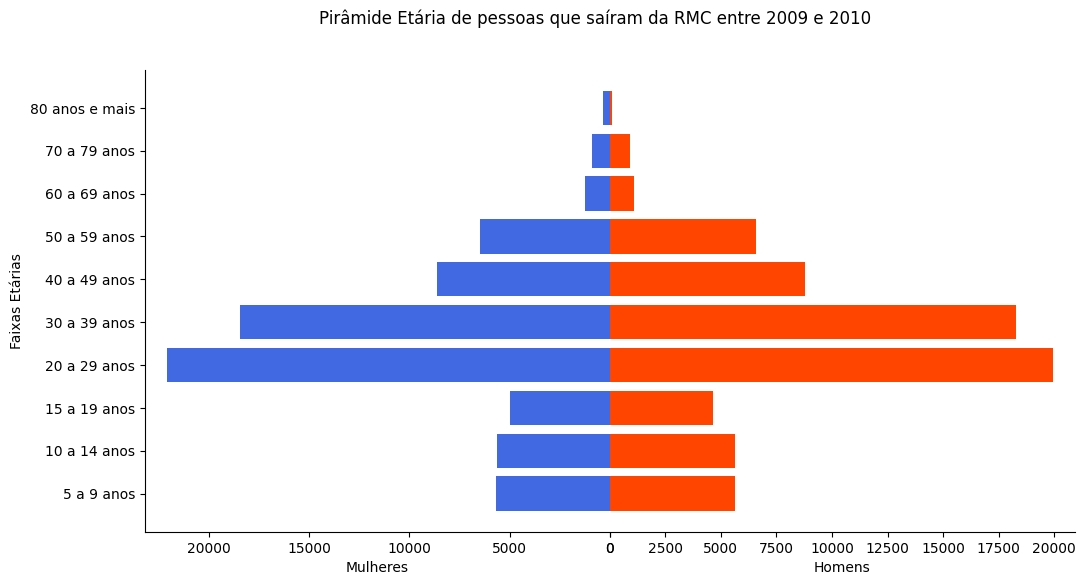

In [60]:
# Separação de dados por sexo
female_data = df_saidas.reset_index()[df_saidas.reset_index()['Sexo'] == 'Feminino']
male_data = df_saidas.reset_index()[df_saidas.reset_index()['Sexo'] == 'Masculino']

# Criação de subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Adição de dados sobre migrantes de sexo feminino ao subplot 1
ax1.barh(female_data['Idade calculada, anos, classe'], female_data['Total'], color='royalblue')
ax1.set_xlabel('Mulheres')
ax1.set_ylabel('Faixas Etárias')
ax1.invert_xaxis()  # Invert the x-axis for female data to go left
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Adição de dados sobre migrantes de sexo masculino ao subplot 2
ax2.barh(male_data['Idade calculada, anos, classe'], male_data['Total'], color='orangered')
ax2.set_xlabel('Homens')
ax2.set_yticks([])  # Remove the y-ticks on the male subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Título da Figura
fig.suptitle('Pirâmide Etária de pessoas que saíram da RMC entre 2009 e 2010')

# Ajuste de espaçamento entre os subplots
plt.subplots_adjust(wspace=0.0) 

# Show the plot
plt.show()


In [63]:
((df_chegadas['Total'] - df_saidas['Total']) / 5).sum()

-161.39999999999995